# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

#### Открытие файла

In [1]:
import pandas as pd

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

#### Общая информация о датафрейме

In [3]:
pd.set_option('max_columns', None)
display(data.tail())
data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,NaN,False,False,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,NaN,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,NaN,False,False,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Гистограмма для числовых значений таблицы

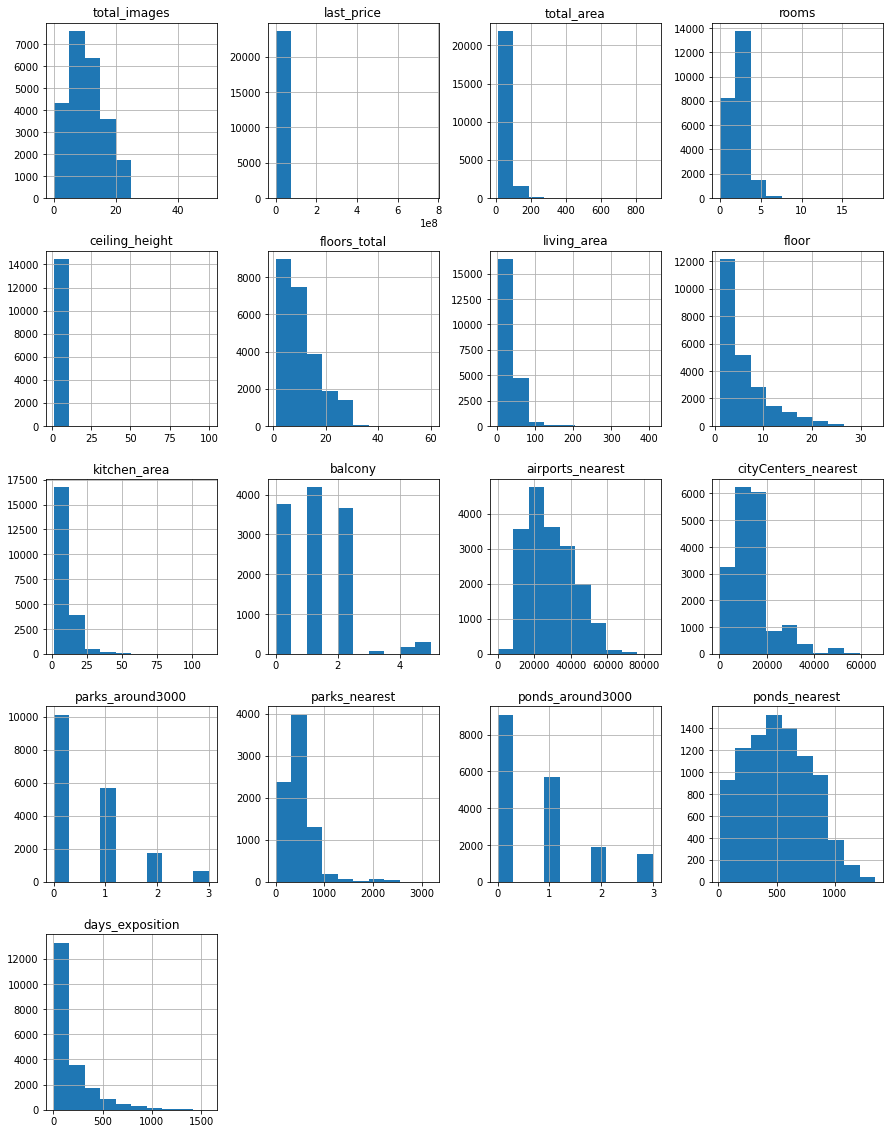

In [4]:
def show_graph(graph):
    return None

show_graph(data.hist(figsize=(15, 20)))

**Вывод раздела.** Открыт файл при помощи библиотеки pandas. В файле наблюдается большое количество пропусков и типов данных, которые не очень подходят к столбцам. На графиках видно большой разброс данных. Файл имеет 23699 строк и 22 столбца.

### Предобработка данных

#### Обработка пропусков

Количество пропущенных значений в столбцах таблицы

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Причины пропусков могут быть разными. В большинстве случаев, скорее всего, продавец просто не указал данные (высота потолков, количество этажей в доме, населённый пункт). В некоторых случаях пропущены значения, которые равнялись нулю или False (количество балконов, парков, водоёмов). В остальных случаях данные скорее всего отсутствовали и их было невозможно получить (расстояние до объектов). К примеру, если получить уникальные значения количества водоёмов в тех местах, где были пропуски в расстоянии до водоёмов, то можно увидеть, что данных либо нет, либо в этих местах нет водоёмов на растоянии 3000 метров.

In [6]:
data.loc[data['ponds_nearest'].isna(), 'ponds_around3000'].unique()

array([ 0., nan])

То же самое с парками.

In [7]:
data.loc[data['parks_nearest'].isna(), 'parks_around3000'].unique()

array([ 0., nan])

Заполнение пропусков значениями

In [8]:
#Апартаменты. При отсутствии данных дом не будет являться апартаментами
data['is_apartment'] = data['is_apartment'].fillna(False)
#Балконы. При отсутствии данных балкона нет
data['balcony'] = data['balcony'].fillna(0)
#Водоёмы. При отсутствии данных водоёмов рядом нет
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
#Парки. При отсутствии данных парков рядом нет
data['parks_around3000'] = data['parks_around3000'].fillna(0)
#Высота потолков. Пропуски заполняются медианным значением
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Удаление строк без населённого пункта

In [9]:
data = data[~(data['locality_name'].isna())]

#### Изменение типов данных

Вывод столбцов и их типов данных

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Значения столбца `first_day_exposition` необходимо проеобразовать в datetime.

Многие столбцы имеют тип данных float64, хотя не содержат в себе дробных значений. Их необходимо преобразовать в integer.

In [11]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['last_price'] = pd.to_numeric(data['last_price'], downcast='integer')
data['floors_total'] = pd.to_numeric(data['floors_total'], downcast='integer')
data['balcony'] = pd.to_numeric(data['balcony'], downcast='integer')
data['airports_nearest'] = pd.to_numeric(data['airports_nearest'], downcast='integer')
data['cityCenters_nearest'] = pd.to_numeric(data['cityCenters_nearest'], downcast='integer')
data['parks_around3000'] = pd.to_numeric(data['parks_around3000'], downcast='integer')
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'], downcast='integer')
data['ponds_around3000'] = pd.to_numeric(data['ponds_around3000'], downcast='integer')
data['ponds_nearest'] = pd.to_numeric(data['ponds_nearest'], downcast='integer')
data['days_exposition'] = pd.to_numeric(data['days_exposition'], downcast='integer')

Результат изменений

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int32         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

#### Устранение дубликатов

Количество явных дубликатов

In [13]:
data.duplicated().sum()

0

Неявные дубликаты могут встретится только в столбце `locality_name`, так как это единственный столбец с текстовыми данными. Ниже представлен отсортированный массив с уникальными значениями в данном столбце.

In [14]:
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'городск

Можно заметить, что из одних источников слово `посёлок` пишут через букву `е`, а в других через букву `ё`. Исправляю это.

In [15]:
data['locality_name'] = data['locality_name'].apply(lambda locality: locality.replace('поселок', 'посёлок'))

Так как массив данных слишком большой, стараюсь автоматизировать поиск похожих значений.

In [16]:
for locality_name in data['locality_name'].unique():
    check = []
    for locality_name_check in data['locality_name'].unique():
        if locality_name in locality_name_check:
            check.append(locality_name_check)
    if len(check) > 1:
        print(locality_name, check)

Коммунар ['Коммунар', 'посёлок Коммунары']
Кингисепп ['Кингисепп', 'посёлок Кингисеппский']
деревня Старая ['деревня Старая', 'деревня Старая Пустошь']
Мурино ['посёлок Мурино', 'Мурино']
Никольское ['Никольское', 'село Никольское']
Кудрово ['деревня Кудрово', 'Кудрово']
Луга ['Луга', 'посёлок Усть-Луга']
Любань ['Любань', 'посёлок Любань']
деревня Бор ['деревня Бор', 'деревня Борисова Грива']
посёлок Лесное ['посёлок Лесное', 'коттеджный посёлок Лесное']
Высоцк ['село Русско-Высоцкое', 'Высоцк']


Из этих населённых пунктов нас интересуют: Кингисепп и посёлок Кингисеппский, Мурино и посёлок Мурино, Любань и посёлок Любань. Все эти населённые пункты находятся на небольшом расстоянии друг от друга или являются одним и тем же населённым пунктом. Изменяю названия населённых пунктов.

In [17]:
def replace_locality_names(locality_name):
    if locality_name == 'посёлок Кингисеппский':
        return 'Кингисепп'
    if locality_name == 'посёлок Мурино':
        return 'Мурино'
    if locality_name == 'посёлок Любань':
        return 'Любань'
    return locality_name
data['locality_name'] = data['locality_name'].apply(replace_locality_names)

Под конец можно снова проверить количество явных дубликатов

In [18]:
data.duplicated().sum()

0

#### Устранение выбивающихся значений

Для устранения выбивающихся значений стоит рассмотреть гистограммы столбцов.

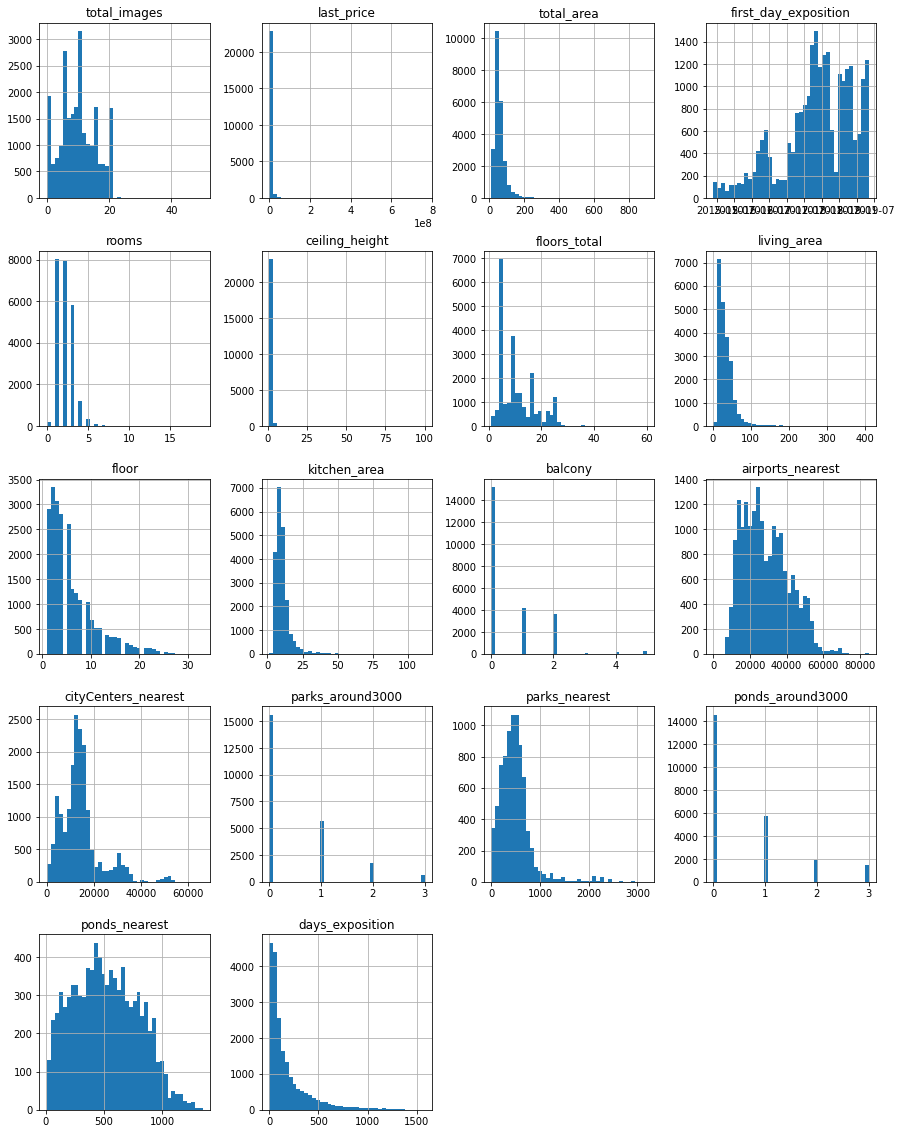

In [19]:
show_graph(data.hist(bins=40, figsize=(15,20)))

Некоторые графики имеют заметные провалы. Устраняю их.

In [20]:
old_shape = data.shape[0]
data = data[(data['last_price'] < 30000000) | (data['last_price'].isna())]
data = data[(data['total_area'] < 200) | (data['total_area'].isna())]
data = data[data['rooms'] != 0]
data = data[(data['rooms'] < 6) | (data['total_area'].isna())]
data['ceiling_height'] = data['ceiling_height'].apply(lambda height: height / 10 if height >= 20 else height)
data = data[(data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 4)]
data = data[(data['floors_total'] < 30) | (data['floors_total'].isna())]
data = data[(data['living_area'] < 120) | (data['living_area'].isna())]
data = data[(data['floor'] < 30) | (data['floor'].isna())]
data = data[(data['kitchen_area'] < 50) | (data['kitchen_area'].isna())]
print('Потеряно данных', round((1 - data.shape[0] / old_shape) * 100), '%')

Потеряно данных 3 %


**Вывод раздела.** Устранены пропуски там, где это было возможно. Изменены типы данных для удобства и экономии памяти. Устранены неявные дубликаты в названиях населённых пунктах. Удалены выбивающиеся значения.

### Посчитайте и добавьте в таблицу новые столбцы

In [21]:
#Добавляю новые столбцы
#Цена одного квадратного метра
data['square_metre_price'] = data['last_price'] / data['total_area']
#День недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['exposition_week_day'] = data['first_day_exposition'].dt.weekday
#Месяц публикации объявления
data['exposition_month'] = data['first_day_exposition'].dt.month
#Год публикации объявления
data['exposition_year'] = data['first_day_exposition'].dt.year
#Тип этажа квартиры (значения — «первый», «последний», «другой»)
def get_floor_type(row):
    if row['floor'] == 1:
        return 'first'
    if row['floor'] == row['floors_total']:
        return 'last'
    return 'other'
data['floor_type'] = data.apply(get_floor_type, axis=1)
#Расстояние до центра города в километрах
data['city_centers_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

**Вывод раздела.** Добавлены новые стобцы:
+ цена одного квадратного метра;
+ день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
+ месяц публикации объявления;
+ год публикации объявления;
+ тип этажа квартиры (значения — «первый», «последний», «другой»);
+ расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

Данные изменения пригодятся в дальнейшей работе.

### Проведите исследовательский анализ данных
#### Исследование параметров
Общая площадь

count    22845.000000
mean        57.151019
std         24.159910
min         12.000000
25%         40.000000
50%         51.400000
75%         68.000000
max        199.200000
Name: total_area, dtype: float64

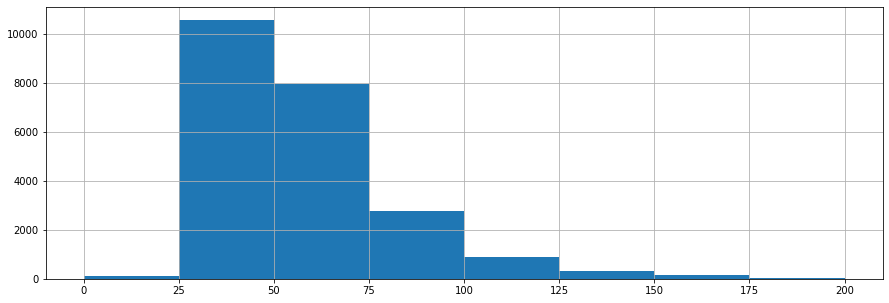

In [22]:
display(data['total_area'].describe())
show_graph(data['total_area'].hist(bins=8, figsize=(15, 5), range=(0, 200)))

Значительное количество объектов (более 50%) имеют площадь от 25 до 50 квадратных метров. Значительный спад происходит после 100 квадратных метров.

Жилая площадь

count    21017.000000
mean        32.606256
std         15.886356
min          2.000000
25%         18.550000
50%         30.000000
75%         41.900000
max        119.900000
Name: living_area, dtype: float64

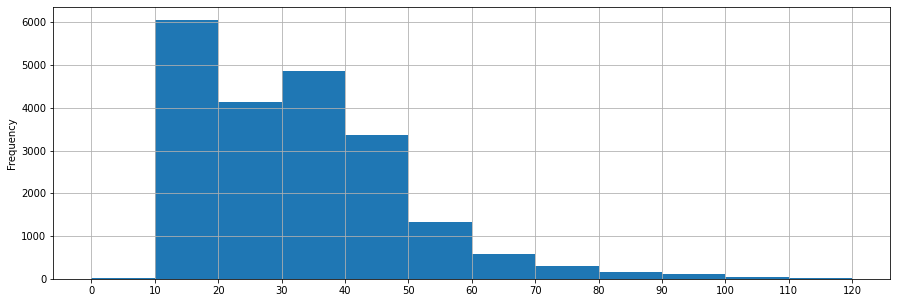

In [23]:
display(data['living_area'].describe())
show_graph(data['living_area'].plot.hist(
    bins=12,
    figsize=(15, 5),
    range=(0, 120),
    xticks=[tick for tick in range(0, 121, 10)],
    grid=True
))

Половина объектов имеют жилую площадь до 30 квадратных метров. Значительный спад происходит после 50 квадратных метров.

Площадь кухни

count    20831.000000
mean        10.183150
std          4.792859
min          1.300000
25%          7.000000
50%          9.000000
75%         11.695000
max         49.400000
Name: kitchen_area, dtype: float64

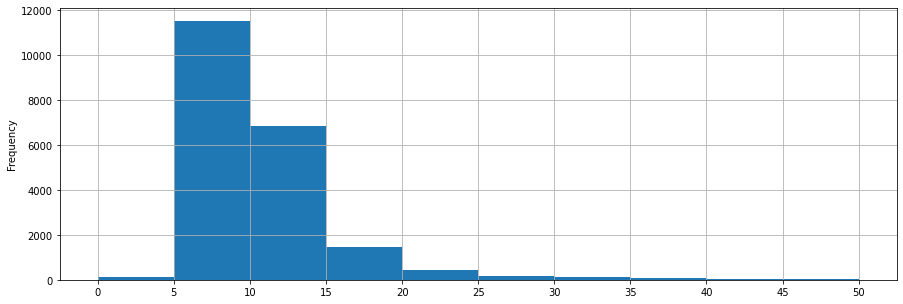

In [24]:
display(data['kitchen_area'].describe())
show_graph(data['kitchen_area'].plot.hist(
    bins=10,
    figsize=(15, 5),
    range=(0, 50),
    xticks=[tick for tick in range(0, 51, 5)],
    grid=True
))

Значительное количество объектов (более 50%) имеют площадь кухни от 5 до 10 квадратных метров. Значительный спад происходит после 15 квадратных метров.

Цена объекта

count    2.284500e+04
mean     5.627021e+06
std      3.795367e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.550000e+06
max      2.999900e+07
Name: last_price, dtype: float64

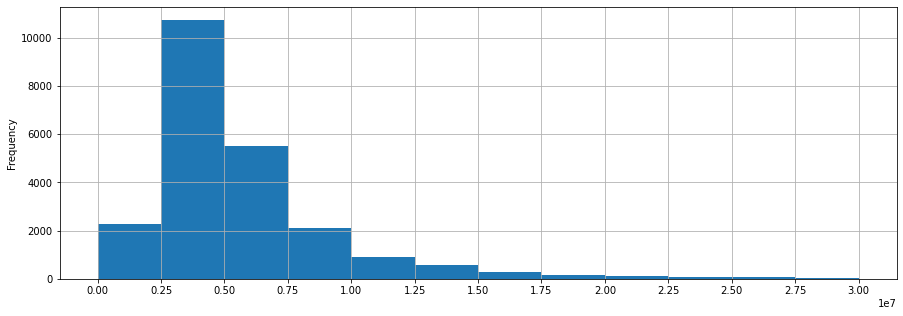

In [25]:
display(data['last_price'].describe())
show_graph(data['last_price'].plot.hist(
    bins=12,
    figsize=(15, 5),
    range=(0, 30000000),
    xticks=[tick for tick in range(0, 30000001, 2500000)],
    grid=True
))

Значительное количество объектов (более 50%) имеют стоимость от 2.5 до 5 миллионов. Значительный спад происходит после 7.5 миллионов.

Количество комнат

count    22845.000000
mean         2.021186
std          0.935818
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

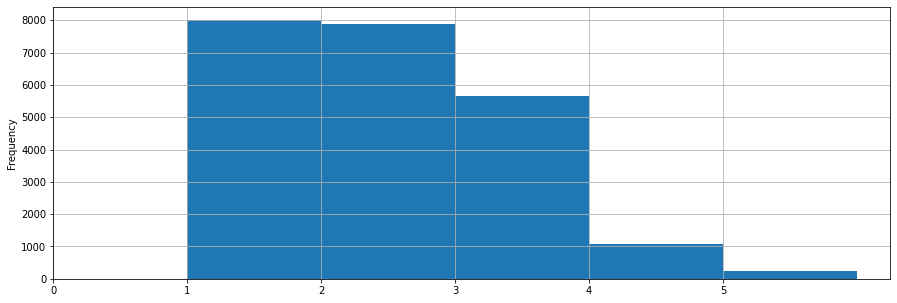

In [26]:
display(data['rooms'].describe())
show_graph(data['rooms'].plot.hist(
    bins=5,
    figsize=(15, 5),
    range=(1, 6),
    xticks=[tick for tick in range(0, 6, 1)],
    grid=True
))

Почти все объекты имеют до трёх комнат (более 75%). Менее 2-ух тысяч объектов (менее 10%) имеют больше 4-ёх комнат.

Высота потолков

count    22845.000000
mean         2.685620
std          0.193342
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64

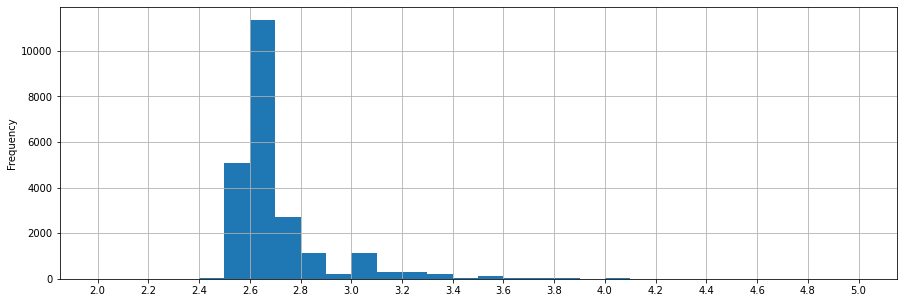

In [27]:
display(data['ceiling_height'].describe())
show_graph(data['ceiling_height'].plot.hist(
    bins=30,
    figsize=(15, 5),
    range=(2, 5),
    xticks=[tick / 100 + 2 for tick in range(0, 301, 20)],
    grid=True
))

В основном высота потолков составляет от 2.6 до 2.7 метра.

Этаж

count    22845.000000
mean         5.880718
std          4.861296
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

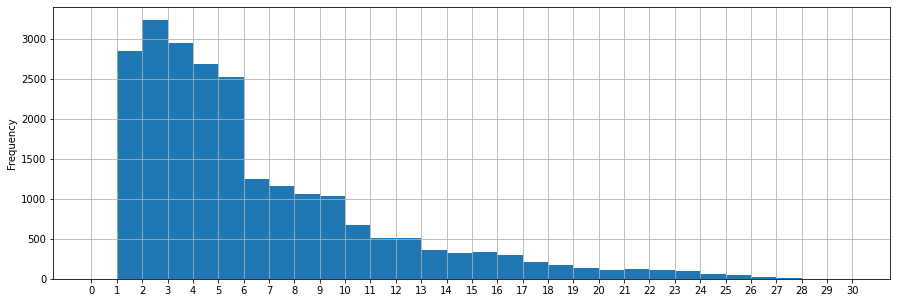

In [28]:
display(data['floor'].describe())
show_graph(data['floor'].plot.hist(
    bins=30,
    figsize=(15, 5),
    range=(0, 30),
    xticks=[tick for tick in range(0, 31, 1)],
    grid=True
))

Более 50% объектов находятся ниже 5-го этажа, более 75% ниже 8-го этажа.

Тип этажа

floor_type
first     2854
last      3183
other    16808
Name: floor_type, dtype: int64

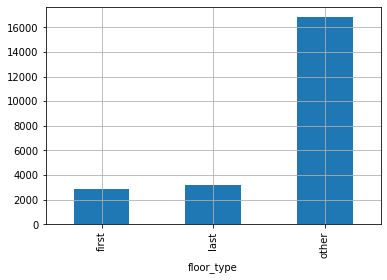

In [29]:
display(data.groupby('floor_type')['floor_type'].count())
show_graph(data.groupby('floor_type')['floor_type'].count().plot.bar(grid=True))

В основном объекты находятся между первым и последним этажом.

Количество этажей в доме

count    22765.000000
mean        10.676697
std          6.531160
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

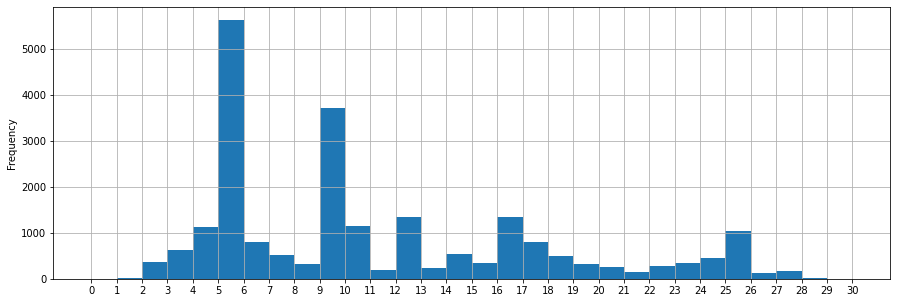

In [30]:
display(data['floors_total'].describe())
show_graph(data['floors_total'].plot.hist(
    bins=30,
    figsize=(15, 5),
    range=(0, 30),
    xticks=[tick for tick in range(0, 31, 1)],
    grid=True
))

В основном в домах 5 или 9 этажей.

Расстояние до центра города

count    17435.000000
mean     14439.168856
std       8585.034906
min        208.000000
25%       9719.000000
50%      13239.000000
75%      16407.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

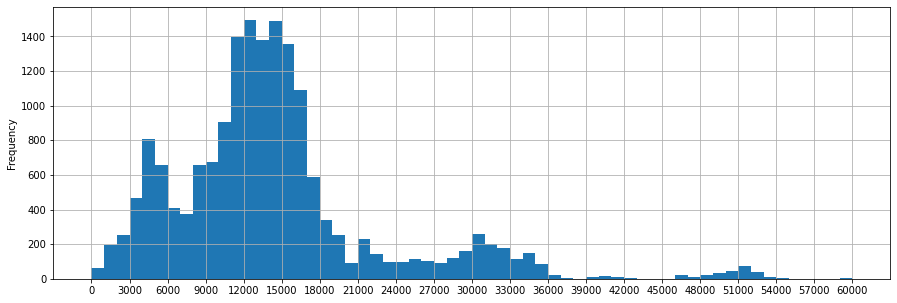

In [31]:
display(data['cityCenters_nearest'].describe())
show_graph(data['cityCenters_nearest'].plot.hist(
    bins=60,
    figsize=(15, 5),
    range=(0, 60000),
    xticks=[tick for tick in range(0, 60001, 3000)],
    grid=True
))

В основном объекты находятся на расстоянии от центра примерно в 13 км. После 18 км наблюдается спад.

Расстояние до ближайшего парка.

count    7638.000000
mean      494.329798
std       344.752489
min         1.000000
25%       289.000000
50%       456.000000
75%       615.000000
max      3190.000000
Name: parks_nearest, dtype: float64

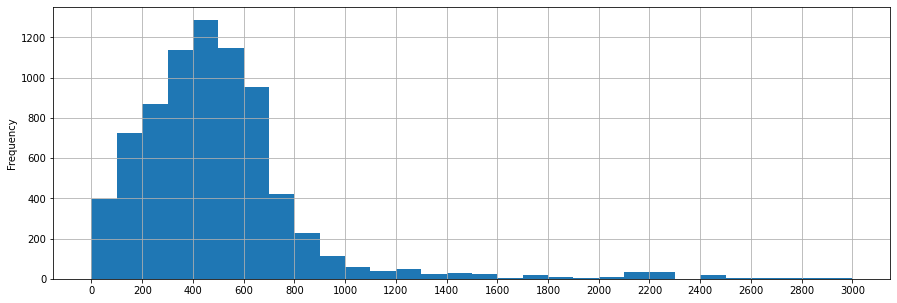

In [32]:
display(data['parks_nearest'].describe())
show_graph(data['parks_nearest'].plot.hist(
    bins=30,
    figsize=(15, 5),
    range=(0, 3000),
    xticks=[tick for tick in range(0, 3001, 200)],
    grid=True
))

В основном парки располагаются недалеко от объектов. Почти в 75% случаев расстояние составляет не более 600 метров. У более половины объектов нет парков поблизости.

Расстояние до ближайшего водоёма

count    8588.000000
mean      524.229739
std       277.234630
min        13.000000
25%       303.000000
50%       507.000000
75%       734.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

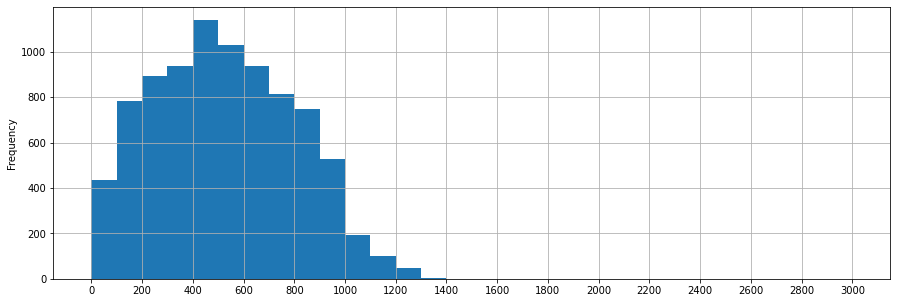

In [33]:
display(data['ponds_nearest'].describe())
show_graph(data['ponds_nearest'].plot.hist(
    bins=30,
    figsize=(15, 5),
    range=(0, 3000),
    xticks=[tick for tick in range(0, 3001, 200)],
    grid=True
))

В основном водоёмы располагаются недалеко от объектов. Почти в 75% случаев расстояние составляет не более 700 метров. У более половины объектов нет водоёмов поблизости.

День недели публикации объявления.

count    22845.000000
mean         2.565288
std          1.791899
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: exposition_week_day, dtype: float64

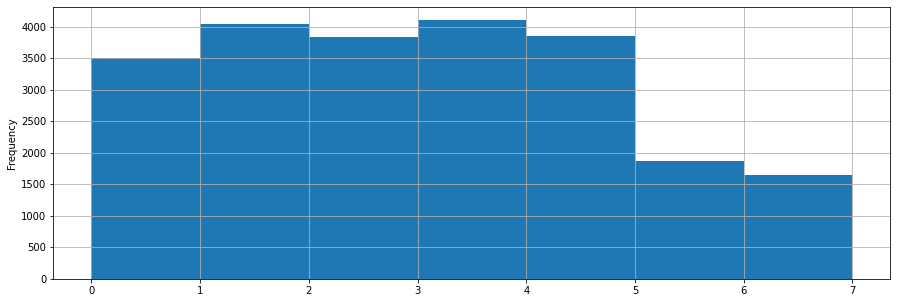

In [34]:
display(data['exposition_week_day'].describe())
show_graph(data['exposition_week_day'].plot.hist(
    bins=7,
    figsize=(15, 5),
    range=(0, 7),
    xticks=[tick for tick in range(0, 8, 1)],
    grid=True
))

В выходные количество публикаций становиться в 2 раза меньше, чем в будние дни.

Месяц публикации объявления

count    22845.000000
mean         6.396411
std          3.489698
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64

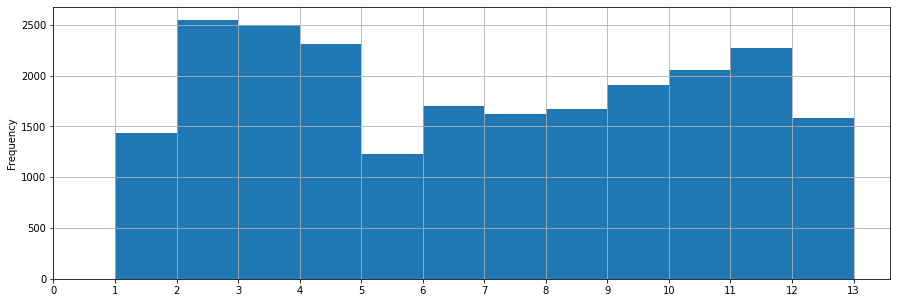

In [35]:
display(data['exposition_month'].describe())
show_graph(data['exposition_month'].plot.hist(
    bins=12,
    figsize=(15, 5),
    range=(1, 13),
    xticks=[tick for tick in range(0, 14, 1)],
    grid=True
))

Данные по месяцам распределены более-менее равномерно.

**Вывод** Большинство параметров имеют нормальное распределение данных. Почти у каждого параметра есть свой подъём, точка максимума и спад.

#### Скорость продажи квартир

count    19830.000000
mean       178.979324
std        217.478618
min          1.000000
25%         45.000000
50%         95.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

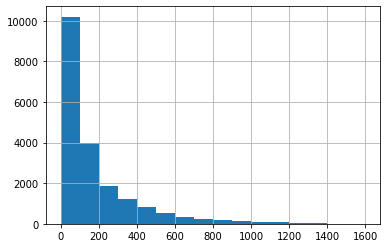

In [36]:
show_graph(data['days_exposition'].hist(bins=16, range=(0, 1600)))
data['days_exposition'].describe()

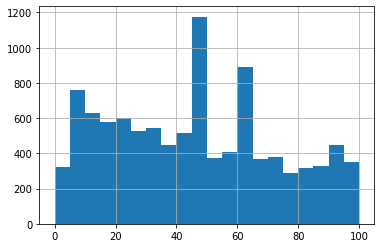

In [37]:
show_graph(data['days_exposition'].hist(bins=20, range=(0, 100)))

**Вывод.** По этим данным видно, что более 50% объектов продают в первые 100 дней. Больше всего продаж приходиться с 45 по 50 и с 60 по 65 дни, поэтому быстрыми будут считаться продажи до 45-го дня (первые 25%). Соответственно последние 25% будут долгими продажами (228 дней и больше). Самая долгая продажа длиласть 1580 дней.

#### Факторы стоимости объекта
Зависимость цены от площади

Корреляция 0.9131553646122633


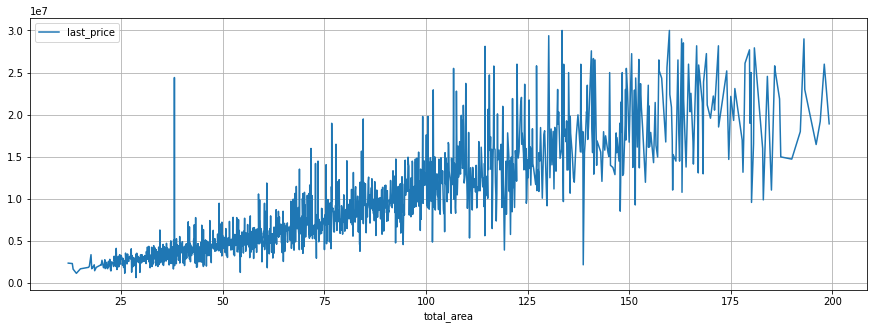

In [38]:
total_area_last_price = data.pivot_table(
    index='total_area',
    values='last_price',
    aggfunc='mean'
)
show_graph(total_area_last_price.plot(grid=True, figsize=(15,5)))
print('Корреляция', total_area_last_price['last_price'].corr(pd.Series(total_area_last_price.index)))

Смотря на график и результат корреляции можно сказать, что зависимость между данными есть.

Зависимость цены от площади кухни

Корреляция 0.8812014275700851


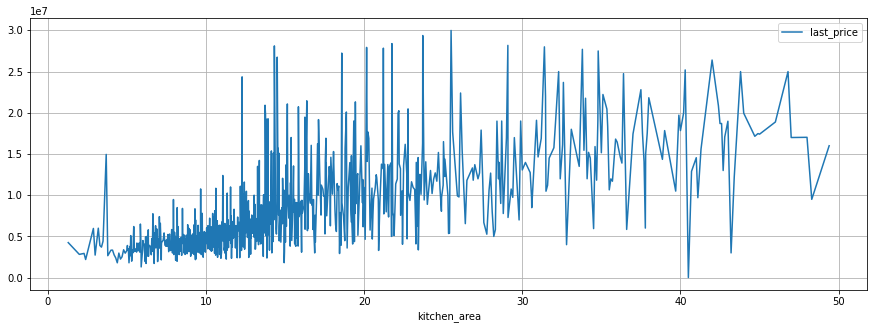

In [39]:
kitchen_area_last_price = data.pivot_table(
    index='kitchen_area',
    values='last_price',
    aggfunc='mean'
)
show_graph(kitchen_area_last_price.plot(grid=True, figsize=(15,5)))
print('Корреляция', kitchen_area_last_price['last_price'].corr(pd.Series(kitchen_area_last_price.index)))

Здесь связь уже не такая очевидная, да и корреляция ниже, однако всё же можно сказать, что зависить цены от площади кухни всё же есть.

Зависимость цены от жилой площади

Корреляция 0.7843010240516758


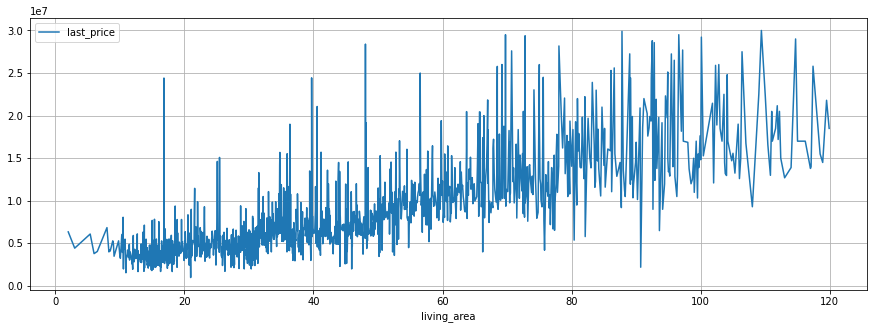

In [40]:
living_area_last_price = data.pivot_table(
    index='living_area',
    values='last_price',
    aggfunc='mean'
)
show_graph(living_area_last_price.plot(grid=True, figsize=(15,5)))
print('Корреляция', living_area_last_price['last_price'].corr(pd.Series(living_area_last_price.index)))

Зависимость от площади жилья ещё ниже. Скорее всего на неё сильно влияет разброс данных после 200 квадратных метров. Можно сказать, что зависимость есть.

Зависимость цены от количества комнат

Корреляция 0.9920225618526005


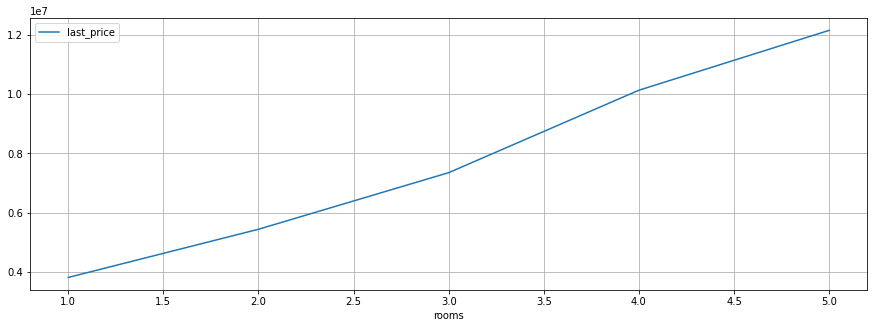

In [41]:
rooms_last_price = data.pivot_table(
    index='rooms',
    values='last_price',
    aggfunc='mean'
)
show_graph(rooms_last_price.plot(grid=True, figsize=(15,5)))
print('Корреляция', rooms_last_price['last_price'].corr(pd.Series(rooms_last_price.index)))

Здесь точно можно сказать, что количество комнат не влияет на стоимость жилья.

Зависимость цены от этажа

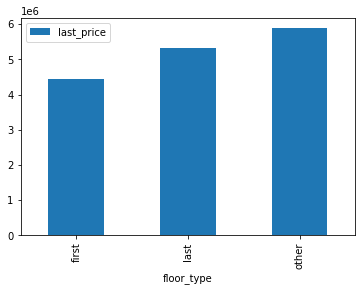

In [42]:
floor_type_last_price = data.pivot_table(
    index='floor_type',
    values='last_price',
    aggfunc='mean'
).sort_values(by='last_price')
show_graph(floor_type_last_price.plot(kind='bar'))

Объекты на первом этаже стоят примерно на 2 миллиона дешевле объектов на других этажах. Объекты на последнем этаже самые дорогие.

Зависимость цены от даты размещения

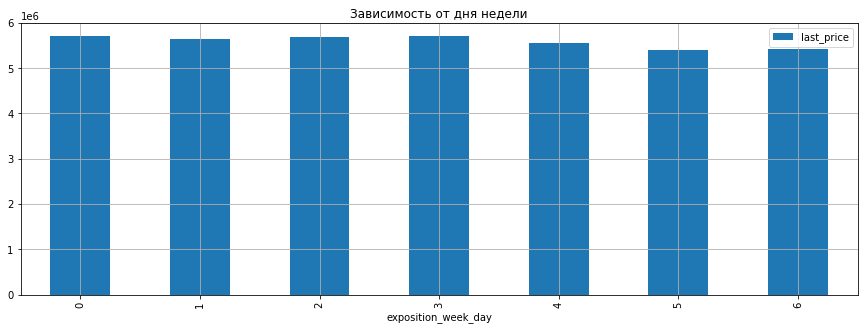

In [43]:
exposition_week_day_last_price = data.pivot_table(
    index='exposition_week_day',
    values='last_price',
    aggfunc='mean'
)
show_graph(exposition_week_day_last_price.plot(kind='bar', grid=True, figsize=(15,5), title='Зависимость от дня недели'))

In [ ]:
exposition_month_last_price = data.pivot_table(
    index='exposition_month',
    values='last_price',
    aggfunc='mean'
)
show_graph(exposition_month_last_price.plot(kind='bar', grid=True, figsize=(15,5), title='Зависимость от месяца'))

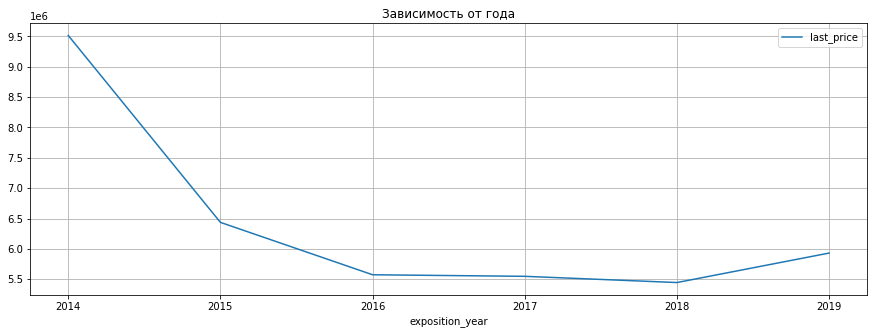

In [45]:
exposition_year_last_price = data.pivot_table(
    index='exposition_year',
    values='last_price',
    aggfunc='mean'
)
show_graph(exposition_year_last_price.plot(grid=True, figsize=(15,5), title='Зависимость от года'))
exposition_year_last_price

Анализируя эти графики, можно сказать, что цена объекта никак не зависит от дня недели или месяца, в который он был размещён, но цена зависит от года размещения. График показывает сильный спад до 2018 года и небольшой подъём в 2019 году.

**Вывод.** Зависимость цены от общей площади, жилой площади и пощади кухни подтверждена. Так или иначе эти факторы влияют на окончательную стоимость объекта. Ниже приводятся значения корреляции.
+ Общая площадь = 0.91
+ Площадь кухни = 0.88
+ Жилая площадь = 0.78

Цена не зависит от количества комнат, однако на цену влияет этаж объекта. На первом этаже стоимость объектов в среднем составляет около 4.5 миллионов, что ниже чем у объектов на других этажах. Объекты на других этажах продаются примерно за 6 миллионов, а объекты на последних этажах - за 5.5 миллионов.
День недели и месяц выставления объекта на продажу не влияют на цену. Год же оказывает значительное влияние: с 2014 по 2018 годы средняя стоимость объектов упала с 9.5 миллионов до 5.5 и поднялась только в 2019 году до почти 6 миллионов.

#### Средняя цена квадратного метра в населённых пунктах

<AxesSubplot:xlabel='locality_name'>

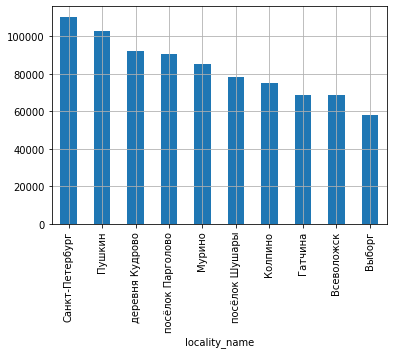

In [46]:
(data.pivot_table(
    index='locality_name',
    values='square_metre_price',
    aggfunc=['mean', 'count']
).droplevel(1, axis=1)
 .sort_values(by='count', ascending=False)
 .head(10)['mean']
 .sort_values(ascending=False)
 .plot(kind='bar', grid=True)
)

**Вывод.** Дороже всего квадратный метр стоит в Санкт-Петербурге. Его средняя стоимость около 110 тысяч. Самый дешёвый квадратный метр в Выборге. Средняя стоимость там составляет примерно 58 тысяч.

#### Средняя цена километра в Санкт-Петербурге

,mean,count
city_centers_nearest_km,,
0.0,112706.249699,12
1.0,144878.394013,161
2.0,129360.789661,250
3.0,117312.569205,313
4.0,125744.120383,619
5.0,132593.082354,816
6.0,131276.711836,521
7.0,131650.817238,362
8.0,123353.074410,578


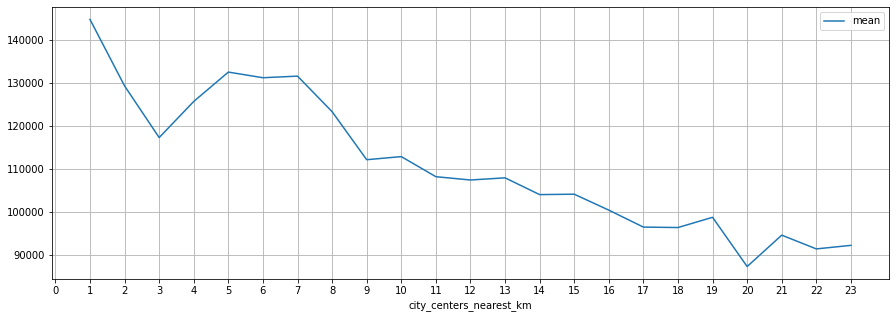

In [47]:
spb_square_metre_price_data = data[data['locality_name'] == 'Санкт-Петербург'].pivot_table(
    index='city_centers_nearest_km',
    values='square_metre_price',
    aggfunc=['mean', 'count']
).droplevel(1, axis=1)
show_graph(
    spb_square_metre_price_data.loc[1:23, :].plot(
        y='mean',
        figsize=(15, 5),
        grid=True,
        xticks=[tick for tick in range(24)],
    )
)
spb_square_metre_price_data

График немного урезан из-за маленькой выборки в областях начала и конча.

**Вывод.** На первых 3 километрах наблюдается сильный спад от 140 тысяч до 120 тысяч за квадратный метр. Далее до 5-го километра можно наблюдать небольшой подъём цен примерно до 130 тысяч и держится на этом уровне до 7-го километра. После седьмого километра снова идёт плавное падение средней цены. Данные последних шести километров нет смысла рассматривать из-за маленькой выборки.

**Вывод раздела.** Изучены параметры объектов. Проведён анализ скорости продажи объектов. Рассмотрены факторы, влияющие на стоимость объекта. Найдена средняя цена стоимости квадратного метра в 10 городах, а также средняя цена расстояния от центра в Санкт-Петербурге.

### Общий вывод

В данной работе продились исследования данных сервиса Яндекс Недвижимость, в которых содержится объявления за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

В ходе выполнения проекта были выполнены задачи:
+ Открыт файл с данными и изучена общаю информация;
+ Выполнена предобработка данных (заполнение пустых значений, изменение типов данных, устранение дубликатов и выбросов);
+ Добавлены новые столбцы в таблицу (цена одного квадратного метра,день недели публикации объявления, месяц публикации объявления, год публикации объявления, тип этажа квартиры, расстояние до центра города в километрах);
+ Проведён исследовательский анализ данных (изучены параметры объектов, скорость продажи объектов, факторы влияния на полную стоимость объекта, посчитана средняя цена квадратного метра в населённых пунктах и средняя цена квадратного метра каждого километра от центра Санкт-Петербурга).

По итогам данной работы я делаю следующие выводы.
+ Данные в данной работе в имеют нормальное распределение.
+ Большинство объектов продают в первые 100 дней. Быстрая продажа осуществляется за менее чем 45 дней, а долгая продажа - за 228 дня и более.
+ Цена объекта напрямую зависит от общей площади, жилой площади, площади кухни, этажа, на котором находиться объект, и года публикации объявления. Количество комнат, день недели и месяц публикации объявления не оказывают на цену влияния.
+ Самый дорогой квадратный метр в Санкт-Петербурге (110 тысяч), а самый дешёвый - в Выборге (58 тысяч).
+ При удалении от центра стоимость за квадратный метр объекта постепенно уменьшается.

При учёте всех этих факторов можно повысить эффективность при продаже недвижимости.